# DLBasics2023 最終課題
実行結果付き。
参考データ収集用.（Cosine Annealing 200回）
### 作者： tfujiwara
### 日付： 2023-Aug-02

## 課題
第11回「変分オートエンコーダ（VAE）を用いてFasionMNISTの画像を生成してみましょう」<br>
を発展させ、学習率探索プログラムを開発する

### 目標

課題の目標値は「NLL（負の対数尤度） 235」であったが、これにこだわらず、
自動探索により、良い検証結果の出る学習率が得られることとする。
以下の、オリジナル課題ルールは、あえて変更せず、**学習率とエポック数以外の条件を固定した中で、最良の検証結果を出す。**

### オリジナル課題ルール

- 訓練データは`x_train`，テストデータは`x_test`で与えられます．
- 下のセルで指定されている`x_train`以外の学習データは使わないでください．

### 評価方法

- 評価は生成画像の検証データに対するNLL（負の対数尤度）とした。<br>（オリジナル課題は、テストデータに対するNLL）

\begin{equation}
-\sum_{i=1}^Dx_i\log\hat{x_i}+(1-x_i)\log(1-\hat{x_i})
\end{equation}

### 評価方法

- 評価は生成画像のテストデータに対するNLL（負の対数尤度）で行います．

\begin{equation}
-\sum_{i=1}^Dx_i\log\hat{x_i}+(1-x_i)\log(1-\hat{x_i})
\end{equation}

- 提出後**テストデータの一部で**即時採点を行い，Leader Boardを更新します．
- 締切後**テストデータ全体で**採点を行い，そのNLLを最終的な評価とします．

### ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み（このセルは修正しないでください）

In [ ]:
import numpy as np
import pandas as pd
import torch

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

# 学習データ
x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_train.npy')
# テストデータ
x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_test.npy')


class dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test.reshape(-1, 784).astype('float32') / 255

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

trainval_data = dataset(x_train)
test_data = dataset(x_test)

### VAEの実装


In [ ]:
batch_size = 32

val_size = 10000
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from typing import Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"


# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデルの実装
class VAE(nn.Module):
    # WRITE ME
    def __init__(self, z_dim: int) -> None:
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction

自分の関数の追加

In [ ]:
import datetime
import pytz
import math
timezone = 'Europe/Budapest'

def datetime_now():
    new_timezone = pytz.timezone(timezone)
    return datetime.datetime.now().astimezone(new_timezone)

class XPrint:
    ### 画面と同じものを記録する。
    def __init__(self, filename, mystr):
        self.filename = filename
        if ( mystr != "" ):
            self.message_time(mystr)
    def __call__(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
    def message(self, mystr):
        try:
            with open(self.filename, "a") as f:
                f.write("{}\n".format(mystr))
        except FileNotFoundError:
            print("* "+mystr)
            return
        print("  "+mystr)
    def message_time(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
xprint = XPrint('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/xprint{}.txt'.format(datetime_now().strftime("%Y%m%d")), "")

class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)
        return lr

  2023/07/29 07:25:14 EPOCH:1, Train Lower Bound:299.499268, (9.411429, 290.087799), Valid Lower Bound:261.661377 lr=0.00020000 最小値更新
  2023/07/29 07:25:21 EPOCH:2, Train Lower Bound:257.724640, (11.244429, 246.480225), Valid Lower Bound:250.890182 lr=0.00040000 最小値更新
  2023/07/29 07:25:29 EPOCH:3, Train Lower Bound:250.511124, (11.533878, 238.977249), Valid Lower Bound:244.923721 lr=0.00060000 最小値更新
  2023/07/29 07:25:36 EPOCH:4, Train Lower Bound:247.261093, (11.951745, 235.309372), Valid Lower Bound:243.061096 lr=0.00080000 最小値更新
  2023/07/29 07:25:44 EPOCH:5, Train Lower Bound:245.404068, (12.173011, 233.231064), Valid Lower Bound:241.851944 lr=0.00100000 最小値更新
  2023/07/29 07:25:51 EPOCH:6, Train Lower Bound:243.813019, (12.392448, 231.420563), Valid Lower Bound:239.925415 lr=0.00100000 最小値更新
  2023/07/29 07:26:01 EPOCH:7, Train Lower Bound:242.808624, (12.530955, 230.277695), Valid Lower Bound:239.549774 lr=0.00099994 最小値更新
  2023/07/29 07:26:08 EPOCH:8, Train Lower Bound:242.095

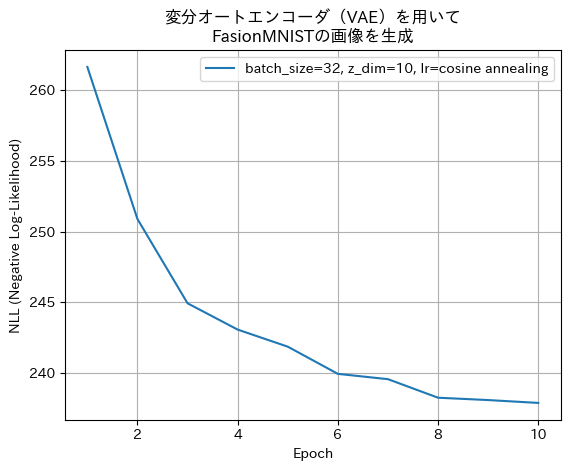

  2023/07/29 07:26:31 EPOCH:11, Train Lower Bound:240.682602, (12.716171, 227.966415), Valid Lower Bound:237.654175 lr=0.00099838 最小値更新
  2023/07/29 07:26:39 EPOCH:12, Train Lower Bound:240.446228, (12.751013, 227.695206), Valid Lower Bound:237.368515 lr=0.00099767 最小値更新
  2023/07/29 07:26:46 EPOCH:13, Train Lower Bound:240.175964, (12.770588, 227.405380), Valid Lower Bound:237.444885 lr=0.00099682 
  2023/07/29 07:26:54 EPOCH:14, Train Lower Bound:239.943970, (12.802155, 227.141830), Valid Lower Bound:236.802170 lr=0.00099585 最小値更新
  2023/07/29 07:27:01 EPOCH:15, Train Lower Bound:239.766769, (12.793494, 226.973282), Valid Lower Bound:237.132568 lr=0.00099475 
  2023/07/29 07:27:09 EPOCH:16, Train Lower Bound:239.587677, (12.815510, 226.772156), Valid Lower Bound:236.624176 lr=0.00099353 最小値更新
  2023/07/29 07:27:17 EPOCH:17, Train Lower Bound:239.472717, (12.820905, 226.651810), Valid Lower Bound:236.988419 lr=0.00099217 
  2023/07/29 07:27:24 EPOCH:18, Train Lower Bound:239.329071, (

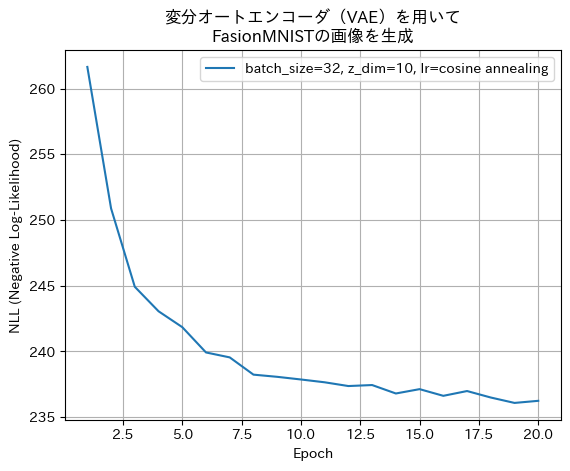

  2023/07/29 07:27:48 EPOCH:21, Train Lower Bound:238.978851, (12.877630, 226.101227), Valid Lower Bound:236.190063 lr=0.00098547 
  2023/07/29 07:27:55 EPOCH:22, Train Lower Bound:238.889969, (12.886503, 226.003464), Valid Lower Bound:236.040405 lr=0.00098348 最小値更新
  2023/07/29 07:28:03 EPOCH:23, Train Lower Bound:238.799164, (12.882625, 225.916519), Valid Lower Bound:236.042450 lr=0.00098136 
  2023/07/29 07:28:10 EPOCH:24, Train Lower Bound:238.703339, (12.893950, 225.809402), Valid Lower Bound:235.812454 lr=0.00097912 最小値更新
  2023/07/29 07:28:18 EPOCH:25, Train Lower Bound:238.609924, (12.906781, 225.703156), Valid Lower Bound:236.435577 lr=0.00097676 
  2023/07/29 07:28:25 EPOCH:26, Train Lower Bound:238.519318, (12.905878, 225.613434), Valid Lower Bound:235.727982 lr=0.00097427 最小値更新
  2023/07/29 07:28:33 EPOCH:27, Train Lower Bound:238.474396, (12.916663, 225.557724), Valid Lower Bound:235.836868 lr=0.00097166 
  2023/07/29 07:28:41 EPOCH:28, Train Lower Bound:238.405777, (12.91

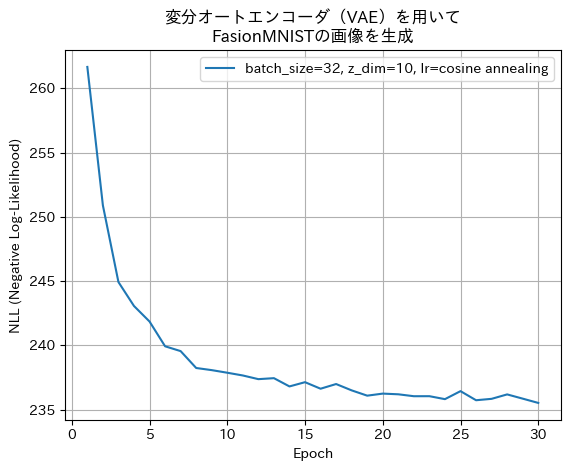

  2023/07/29 07:29:03 EPOCH:31, Train Lower Bound:238.242340, (12.944198, 225.298141), Valid Lower Bound:235.842453 lr=0.00095999 
  2023/07/29 07:29:11 EPOCH:32, Train Lower Bound:238.177231, (12.949399, 225.227798), Valid Lower Bound:235.755722 lr=0.00095677 
  2023/07/29 07:29:19 EPOCH:33, Train Lower Bound:238.131348, (12.954708, 225.176651), Valid Lower Bound:235.471527 lr=0.00095344 最小値更新
  2023/07/29 07:29:26 EPOCH:34, Train Lower Bound:238.077042, (12.971032, 225.105988), Valid Lower Bound:235.639282 lr=0.00094998 
  2023/07/29 07:29:34 EPOCH:35, Train Lower Bound:238.048492, (12.983565, 225.064911), Valid Lower Bound:236.000504 lr=0.00094641 
  2023/07/29 07:29:42 EPOCH:36, Train Lower Bound:237.938751, (12.956901, 224.981842), Valid Lower Bound:235.204376 lr=0.00094273 最小値更新
  2023/07/29 07:29:50 EPOCH:37, Train Lower Bound:237.899643, (12.989399, 224.910263), Valid Lower Bound:235.523987 lr=0.00093893 
  2023/07/29 07:29:57 EPOCH:38, Train Lower Bound:237.913330, (13.001964,

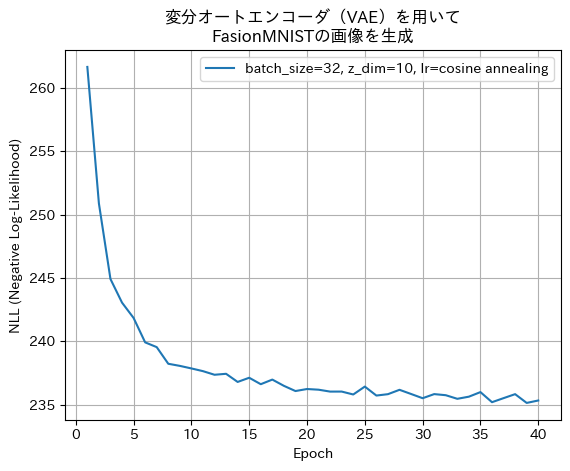

  2023/07/29 07:30:20 EPOCH:41, Train Lower Bound:237.745758, (13.003035, 224.742737), Valid Lower Bound:235.464127 lr=0.00092260 
  2023/07/29 07:30:28 EPOCH:42, Train Lower Bound:237.693436, (13.019717, 224.673691), Valid Lower Bound:235.209167 lr=0.00091824 
  2023/07/29 07:30:36 EPOCH:43, Train Lower Bound:237.684326, (13.023529, 224.660812), Valid Lower Bound:235.244232 lr=0.00091377 
  2023/07/29 07:30:44 EPOCH:44, Train Lower Bound:237.625305, (13.021384, 224.603928), Valid Lower Bound:234.997833 lr=0.00090919 最小値更新
  2023/07/29 07:30:51 EPOCH:45, Train Lower Bound:237.634048, (13.050261, 224.583801), Valid Lower Bound:235.249725 lr=0.00090451 
  2023/07/29 07:30:59 EPOCH:46, Train Lower Bound:237.573242, (13.037971, 224.535278), Valid Lower Bound:235.089554 lr=0.00089972 
  2023/07/29 07:31:07 EPOCH:47, Train Lower Bound:237.510635, (13.023252, 224.487396), Valid Lower Bound:234.752289 lr=0.00089483 最小値更新
  2023/07/29 07:31:14 EPOCH:48, Train Lower Bound:237.472183, (13.013661,

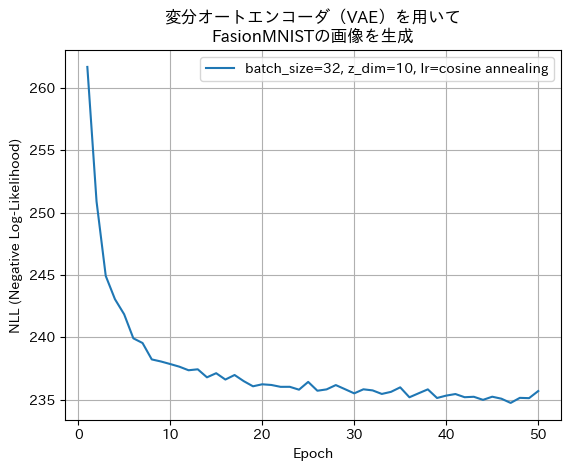

  2023/07/29 07:31:38 EPOCH:51, Train Lower Bound:237.428146, (13.086926, 224.341217), Valid Lower Bound:235.030075 lr=0.00087426 
  2023/07/29 07:31:45 EPOCH:52, Train Lower Bound:237.400391, (13.072589, 224.327805), Valid Lower Bound:234.760986 lr=0.00086887 
  2023/07/29 07:31:53 EPOCH:53, Train Lower Bound:237.309921, (13.075742, 224.234192), Valid Lower Bound:234.839661 lr=0.00086338 
  2023/07/29 07:32:01 EPOCH:54, Train Lower Bound:237.266205, (13.046254, 224.219955), Valid Lower Bound:235.233871 lr=0.00085780 
  2023/07/29 07:32:09 EPOCH:55, Train Lower Bound:237.271317, (13.083576, 224.187729), Valid Lower Bound:234.881683 lr=0.00085213 
  2023/07/29 07:32:17 EPOCH:56, Train Lower Bound:237.214966, (13.064027, 224.150940), Valid Lower Bound:234.906876 lr=0.00084636 
  2023/07/29 07:32:24 EPOCH:57, Train Lower Bound:237.195953, (13.074242, 224.121704), Valid Lower Bound:235.010834 lr=0.00084051 
  2023/07/29 07:32:32 EPOCH:58, Train Lower Bound:237.179901, (13.065189, 224.11471

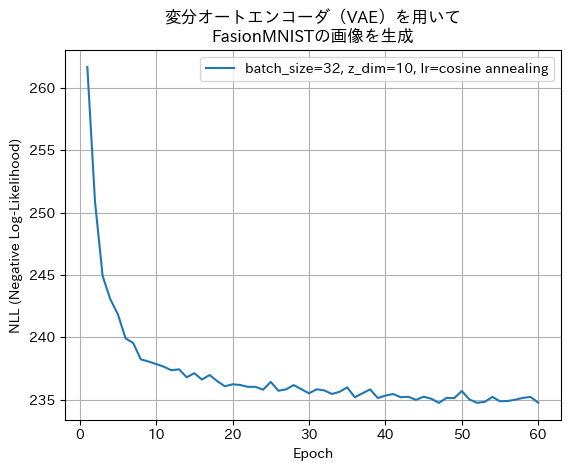

  2023/07/29 07:32:56 EPOCH:61, Train Lower Bound:237.072586, (13.082339, 223.990265), Valid Lower Bound:235.228577 lr=0.00081622 
  2023/07/29 07:33:03 EPOCH:62, Train Lower Bound:237.045868, (13.073193, 223.972687), Valid Lower Bound:234.691299 lr=0.00080994 最小値更新
  2023/07/29 07:33:11 EPOCH:63, Train Lower Bound:237.011475, (13.102000, 223.909454), Valid Lower Bound:234.842407 lr=0.00080358 
  2023/07/29 07:33:19 EPOCH:64, Train Lower Bound:236.997269, (13.097391, 223.899887), Valid Lower Bound:234.676224 lr=0.00079714 最小値更新
  2023/07/29 07:33:27 EPOCH:65, Train Lower Bound:236.947571, (13.082142, 223.865433), Valid Lower Bound:234.632156 lr=0.00079062 最小値更新
  2023/07/29 07:33:34 EPOCH:66, Train Lower Bound:236.917984, (13.100661, 223.817337), Valid Lower Bound:234.723236 lr=0.00078403 
  2023/07/29 07:33:42 EPOCH:67, Train Lower Bound:236.876724, (13.085361, 223.791351), Valid Lower Bound:234.854538 lr=0.00077737 
  2023/07/29 07:33:50 EPOCH:68, Train Lower Bound:236.874069, (13.12

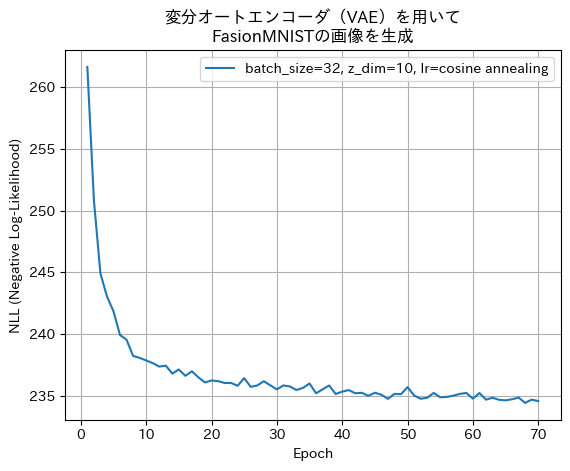

  2023/07/29 07:34:13 EPOCH:71, Train Lower Bound:236.795761, (13.115943, 223.679825), Valid Lower Bound:234.604813 lr=0.00075000 
  2023/07/29 07:34:21 EPOCH:72, Train Lower Bound:236.746658, (13.117383, 223.629288), Valid Lower Bound:234.723572 lr=0.00074299 
  2023/07/29 07:34:28 EPOCH:73, Train Lower Bound:236.728622, (13.108811, 223.619827), Valid Lower Bound:234.562424 lr=0.00073592 
  2023/07/29 07:34:36 EPOCH:74, Train Lower Bound:236.706192, (13.105551, 223.600632), Valid Lower Bound:234.387711 lr=0.00072879 最小値更新
  2023/07/29 07:34:44 EPOCH:75, Train Lower Bound:236.671997, (13.118593, 223.553391), Valid Lower Bound:234.642273 lr=0.00072160 
  2023/07/29 07:34:51 EPOCH:76, Train Lower Bound:236.682693, (13.131018, 223.551682), Valid Lower Bound:234.490540 lr=0.00071435 
  2023/07/29 07:34:59 EPOCH:77, Train Lower Bound:236.643265, (13.148325, 223.494949), Valid Lower Bound:234.506592 lr=0.00070704 
  2023/07/29 07:35:07 EPOCH:78, Train Lower Bound:236.610138, (13.140834, 223.

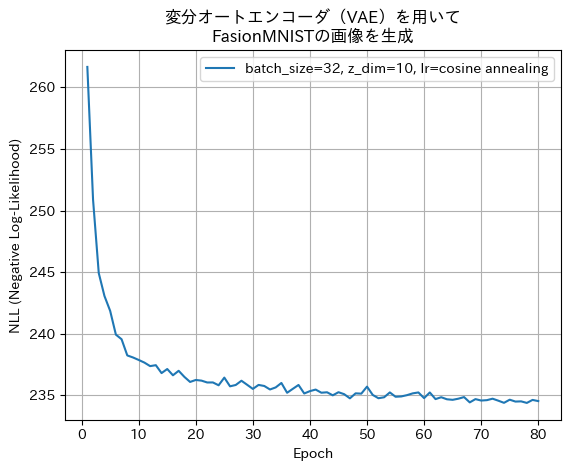

  2023/07/29 07:35:30 EPOCH:81, Train Lower Bound:236.514740, (13.157248, 223.357498), Valid Lower Bound:234.247879 lr=0.00067730 最小値更新
  2023/07/29 07:35:39 EPOCH:82, Train Lower Bound:236.455460, (13.138008, 223.317474), Valid Lower Bound:234.464462 lr=0.00066975 
  2023/07/29 07:35:46 EPOCH:83, Train Lower Bound:236.454315, (13.162168, 223.292145), Valid Lower Bound:234.273743 lr=0.00066215 
  2023/07/29 07:35:54 EPOCH:84, Train Lower Bound:236.431702, (13.163647, 223.268036), Valid Lower Bound:234.548218 lr=0.00065451 
  2023/07/29 07:36:01 EPOCH:85, Train Lower Bound:236.441315, (13.172563, 223.268753), Valid Lower Bound:234.351334 lr=0.00064683 
  2023/07/29 07:36:09 EPOCH:86, Train Lower Bound:236.378189, (13.151535, 223.226654), Valid Lower Bound:234.172623 lr=0.00063911 最小値更新
  2023/07/29 07:36:17 EPOCH:87, Train Lower Bound:236.351852, (13.172650, 223.179199), Valid Lower Bound:234.232285 lr=0.00063135 
  2023/07/29 07:36:24 EPOCH:88, Train Lower Bound:236.341217, (13.166861,

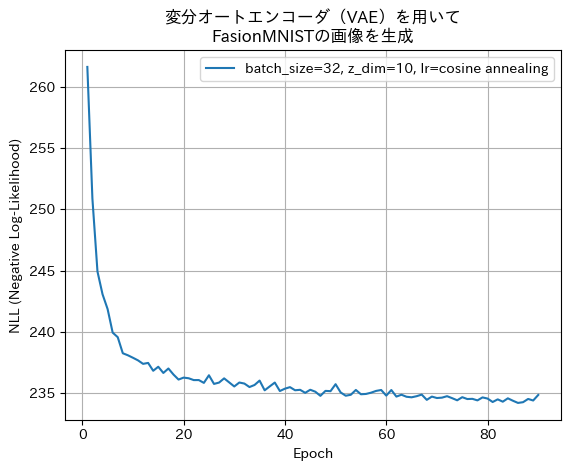

  2023/07/29 07:36:48 EPOCH:91, Train Lower Bound:236.246155, (13.181190, 223.064957), Valid Lower Bound:234.083511 lr=0.00060001 最小値更新
  2023/07/29 07:36:55 EPOCH:92, Train Lower Bound:236.237732, (13.175325, 223.062393), Valid Lower Bound:234.560806 lr=0.00059211 
  2023/07/29 07:37:03 EPOCH:93, Train Lower Bound:236.206039, (13.185727, 223.020309), Valid Lower Bound:234.315201 lr=0.00058418 
  2023/07/29 07:37:11 EPOCH:94, Train Lower Bound:236.194565, (13.183766, 223.010803), Valid Lower Bound:234.470444 lr=0.00057623 
  2023/07/29 07:37:19 EPOCH:95, Train Lower Bound:236.144089, (13.182535, 222.961563), Valid Lower Bound:234.122711 lr=0.00056826 
  2023/07/29 07:37:27 EPOCH:96, Train Lower Bound:236.153046, (13.199448, 222.953613), Valid Lower Bound:234.097839 lr=0.00056027 
  2023/07/29 07:37:34 EPOCH:97, Train Lower Bound:236.092804, (13.188581, 222.904221), Valid Lower Bound:234.170380 lr=0.00055226 
  2023/07/29 07:37:42 EPOCH:98, Train Lower Bound:236.084213, (13.197789, 222.

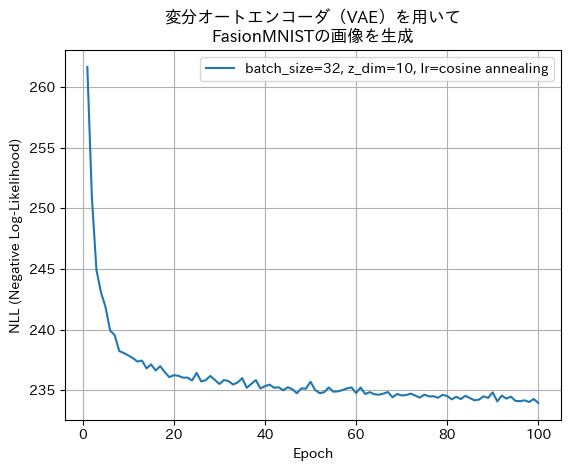

  2023/07/29 07:38:06 EPOCH:101, Train Lower Bound:236.023346, (13.197143, 222.826202), Valid Lower Bound:234.136200 lr=0.00052013 
  2023/07/29 07:38:13 EPOCH:102, Train Lower Bound:236.003433, (13.191647, 222.811783), Valid Lower Bound:234.315598 lr=0.00051208 
  2023/07/29 07:38:21 EPOCH:103, Train Lower Bound:235.982056, (13.218143, 222.763931), Valid Lower Bound:234.158752 lr=0.00050403 
  2023/07/29 07:38:28 EPOCH:104, Train Lower Bound:235.948914, (13.211544, 222.737366), Valid Lower Bound:234.220123 lr=0.00049597 
  2023/07/29 07:38:36 EPOCH:105, Train Lower Bound:235.899673, (13.197459, 222.702225), Valid Lower Bound:234.066986 lr=0.00048792 
  2023/07/29 07:38:43 EPOCH:106, Train Lower Bound:235.872101, (13.198452, 222.673660), Valid Lower Bound:233.979935 lr=0.00047987 
  2023/07/29 07:38:51 EPOCH:107, Train Lower Bound:235.860764, (13.209342, 222.651413), Valid Lower Bound:234.117905 lr=0.00047182 
  2023/07/29 07:38:59 EPOCH:108, Train Lower Bound:235.821701, (13.215944, 2

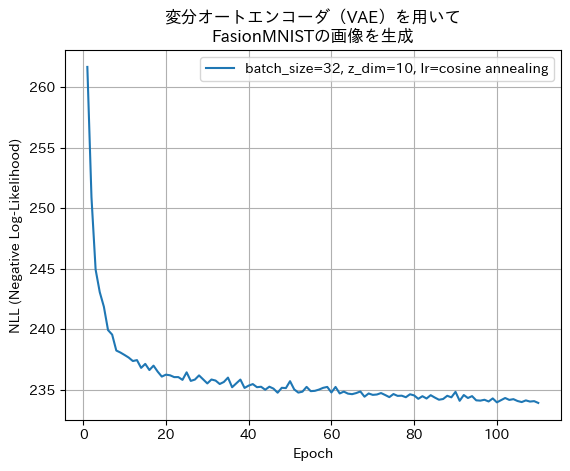

  2023/07/29 07:39:21 EPOCH:111, Train Lower Bound:235.737640, (13.209188, 222.528442), Valid Lower Bound:234.022964 lr=0.00043973 
  2023/07/29 07:39:29 EPOCH:112, Train Lower Bound:235.710999, (13.205919, 222.505066), Valid Lower Bound:234.097824 lr=0.00043174 
  2023/07/29 07:39:36 EPOCH:113, Train Lower Bound:235.685272, (13.220199, 222.465088), Valid Lower Bound:234.063950 lr=0.00042377 
  2023/07/29 07:39:44 EPOCH:114, Train Lower Bound:235.687790, (13.231304, 222.456482), Valid Lower Bound:233.986526 lr=0.00041582 
  2023/07/29 07:39:52 EPOCH:115, Train Lower Bound:235.646759, (13.218187, 222.428574), Valid Lower Bound:233.817444 lr=0.00040789 最小値更新
  2023/07/29 07:39:59 EPOCH:116, Train Lower Bound:235.646744, (13.236112, 222.410614), Valid Lower Bound:234.053482 lr=0.00039999 
  2023/07/29 07:40:07 EPOCH:117, Train Lower Bound:235.604095, (13.217514, 222.386566), Valid Lower Bound:233.866745 lr=0.00039211 
  2023/07/29 07:40:14 EPOCH:118, Train Lower Bound:235.590820, (13.2356

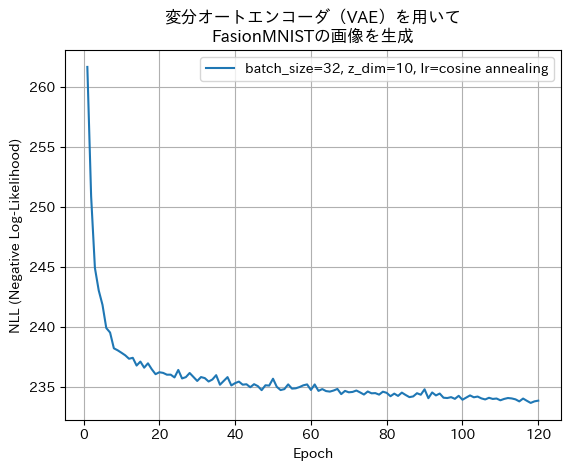

  2023/07/29 07:40:37 EPOCH:121, Train Lower Bound:235.520248, (13.234946, 222.285278), Valid Lower Bound:233.664032 lr=0.00036089 最小値更新
  2023/07/29 07:40:45 EPOCH:122, Train Lower Bound:235.484726, (13.226532, 222.258163), Valid Lower Bound:233.735672 lr=0.00035317 
  2023/07/29 07:40:52 EPOCH:123, Train Lower Bound:235.489655, (13.237783, 222.251907), Valid Lower Bound:233.599213 lr=0.00034549 最小値更新
  2023/07/29 07:41:00 EPOCH:124, Train Lower Bound:235.443527, (13.236841, 222.206680), Valid Lower Bound:233.863724 lr=0.00033785 
  2023/07/29 07:41:07 EPOCH:125, Train Lower Bound:235.427399, (13.232116, 222.195267), Valid Lower Bound:233.794830 lr=0.00033025 
  2023/07/29 07:41:15 EPOCH:126, Train Lower Bound:235.416779, (13.240176, 222.176590), Valid Lower Bound:233.759613 lr=0.00032270 
  2023/07/29 07:41:22 EPOCH:127, Train Lower Bound:235.395844, (13.257596, 222.138245), Valid Lower Bound:233.766876 lr=0.00031519 
  2023/07/29 07:41:30 EPOCH:128, Train Lower Bound:235.383636, (13

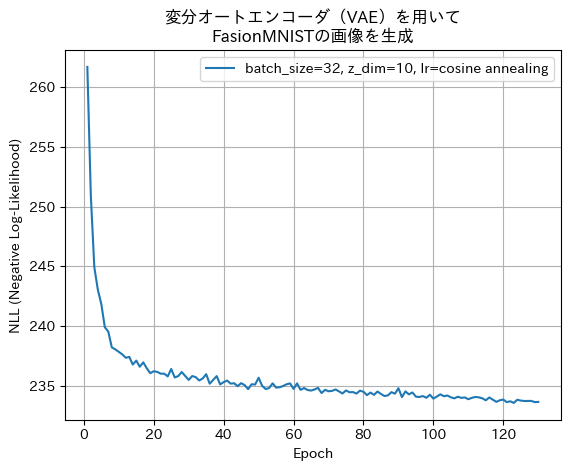

  2023/07/29 07:41:54 EPOCH:131, Train Lower Bound:235.293121, (13.256906, 222.036240), Valid Lower Bound:233.694092 lr=0.00028565 
  2023/07/29 07:42:01 EPOCH:132, Train Lower Bound:235.262314, (13.235733, 222.026581), Valid Lower Bound:233.673630 lr=0.00027840 
  2023/07/29 07:42:09 EPOCH:133, Train Lower Bound:235.261307, (13.261722, 221.999573), Valid Lower Bound:233.719101 lr=0.00027121 
  2023/07/29 07:42:16 EPOCH:134, Train Lower Bound:235.250534, (13.249944, 222.000595), Valid Lower Bound:233.740067 lr=0.00026408 
  2023/07/29 07:42:24 EPOCH:135, Train Lower Bound:235.236755, (13.268287, 221.968460), Valid Lower Bound:233.872208 lr=0.00025701 
  2023/07/29 07:42:32 EPOCH:136, Train Lower Bound:235.213150, (13.265700, 221.947449), Valid Lower Bound:233.415436 lr=0.00025000 最小値更新
  2023/07/29 07:42:39 EPOCH:137, Train Lower Bound:235.212875, (13.290349, 221.922531), Valid Lower Bound:233.492508 lr=0.00024306 
  2023/07/29 07:42:47 EPOCH:138, Train Lower Bound:235.179398, (13.2788

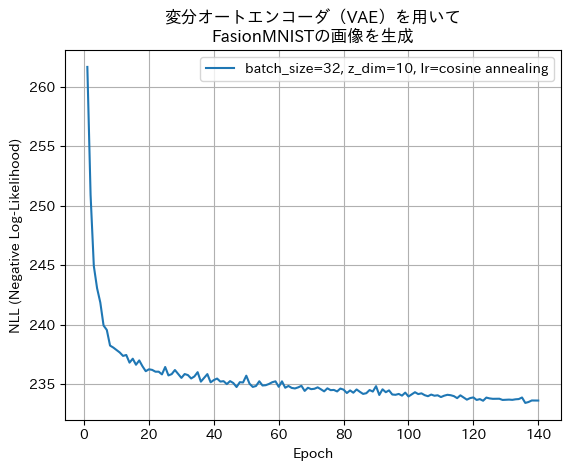

  2023/07/29 07:43:10 EPOCH:141, Train Lower Bound:235.116791, (13.286257, 221.830536), Valid Lower Bound:233.461060 lr=0.00021597 
  2023/07/29 07:43:18 EPOCH:142, Train Lower Bound:235.089798, (13.270254, 221.819534), Valid Lower Bound:233.516022 lr=0.00020938 
  2023/07/29 07:43:26 EPOCH:143, Train Lower Bound:235.088684, (13.284651, 221.804031), Valid Lower Bound:233.479782 lr=0.00020286 
  2023/07/29 07:43:33 EPOCH:144, Train Lower Bound:235.049896, (13.261258, 221.788635), Valid Lower Bound:233.447937 lr=0.00019642 
  2023/07/29 07:43:41 EPOCH:145, Train Lower Bound:235.056717, (13.285888, 221.770828), Valid Lower Bound:233.489319 lr=0.00019006 
  2023/07/29 07:43:49 EPOCH:146, Train Lower Bound:235.008377, (13.274930, 221.733444), Valid Lower Bound:233.416214 lr=0.00018378 
  2023/07/29 07:43:57 EPOCH:147, Train Lower Bound:235.021362, (13.285485, 221.735870), Valid Lower Bound:233.429443 lr=0.00017758 
  2023/07/29 07:44:04 EPOCH:148, Train Lower Bound:235.006439, (13.298667, 2

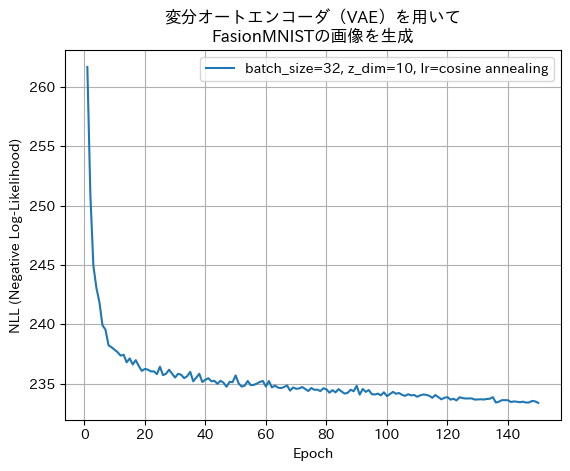

  2023/07/29 07:44:28 EPOCH:151, Train Lower Bound:234.958664, (13.303167, 221.655502), Valid Lower Bound:233.530121 lr=0.00015364 
  2023/07/29 07:44:36 EPOCH:152, Train Lower Bound:234.903549, (13.277048, 221.626495), Valid Lower Bound:233.423721 lr=0.00014787 
  2023/07/29 07:44:43 EPOCH:153, Train Lower Bound:234.912872, (13.287268, 221.625595), Valid Lower Bound:233.530945 lr=0.00014220 
  2023/07/29 07:44:51 EPOCH:154, Train Lower Bound:234.898819, (13.285091, 221.613724), Valid Lower Bound:233.510254 lr=0.00013662 
  2023/07/29 07:44:58 EPOCH:155, Train Lower Bound:234.879929, (13.307091, 221.572845), Valid Lower Bound:233.362869 lr=0.00013113 最小値更新
  2023/07/29 07:45:06 EPOCH:156, Train Lower Bound:234.883972, (13.307360, 221.576614), Valid Lower Bound:233.373428 lr=0.00012574 
  2023/07/29 07:45:14 EPOCH:157, Train Lower Bound:234.855194, (13.299825, 221.555344), Valid Lower Bound:233.359329 lr=0.00012045 最小値更新
  2023/07/29 07:45:21 EPOCH:158, Train Lower Bound:234.838730, (13

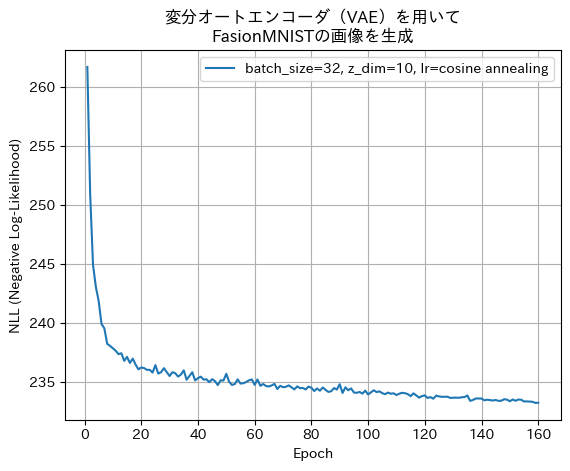

  2023/07/29 07:45:45 EPOCH:161, Train Lower Bound:234.787949, (13.287536, 221.500412), Valid Lower Bound:233.374771 lr=0.00010028 
  2023/07/29 07:45:52 EPOCH:162, Train Lower Bound:234.805832, (13.300458, 221.505371), Valid Lower Bound:233.355225 lr=0.00009549 
  2023/07/29 07:46:00 EPOCH:163, Train Lower Bound:234.784454, (13.311814, 221.472641), Valid Lower Bound:233.371201 lr=0.00009081 
  2023/07/29 07:46:08 EPOCH:164, Train Lower Bound:234.765656, (13.307741, 221.457916), Valid Lower Bound:233.324753 lr=0.00008623 
  2023/07/29 07:46:15 EPOCH:165, Train Lower Bound:234.747696, (13.299536, 221.448166), Valid Lower Bound:233.445908 lr=0.00008176 
  2023/07/29 07:46:23 EPOCH:166, Train Lower Bound:234.727982, (13.297344, 221.430649), Valid Lower Bound:233.293488 lr=0.00007740 
  2023/07/29 07:46:30 EPOCH:167, Train Lower Bound:234.712662, (13.290755, 221.421890), Valid Lower Bound:233.328873 lr=0.00007315 
  2023/07/29 07:46:38 EPOCH:168, Train Lower Bound:234.723999, (13.295555, 2

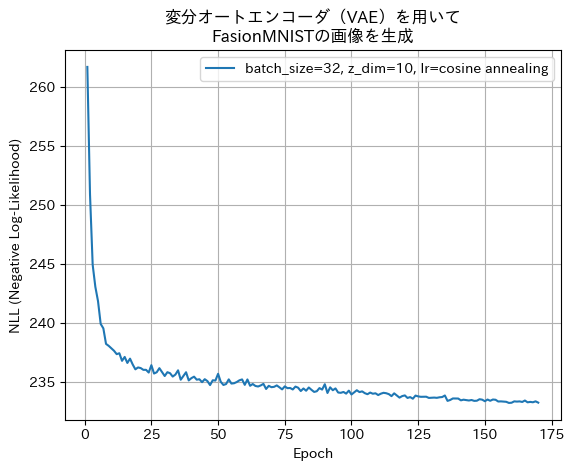

  2023/07/29 07:47:02 EPOCH:171, Train Lower Bound:234.688660, (13.294291, 221.394394), Valid Lower Bound:233.270660 lr=0.00005727 
  2023/07/29 07:47:09 EPOCH:172, Train Lower Bound:234.693817, (13.315068, 221.378769), Valid Lower Bound:233.285248 lr=0.00005359 
  2023/07/29 07:47:17 EPOCH:173, Train Lower Bound:234.691940, (13.317951, 221.373978), Valid Lower Bound:233.326599 lr=0.00005002 
  2023/07/29 07:47:24 EPOCH:174, Train Lower Bound:234.666641, (13.315230, 221.351410), Valid Lower Bound:233.314728 lr=0.00004656 
  2023/07/29 07:47:32 EPOCH:175, Train Lower Bound:234.640610, (13.298604, 221.342010), Valid Lower Bound:233.233978 lr=0.00004323 最小値更新
  2023/07/29 07:47:39 EPOCH:176, Train Lower Bound:234.631271, (13.294322, 221.336945), Valid Lower Bound:233.204529 lr=0.00004001 最小値更新
  2023/07/29 07:47:47 EPOCH:177, Train Lower Bound:234.624863, (13.306300, 221.318542), Valid Lower Bound:233.250748 lr=0.00003691 
  2023/07/29 07:47:55 EPOCH:178, Train Lower Bound:234.628937, (13

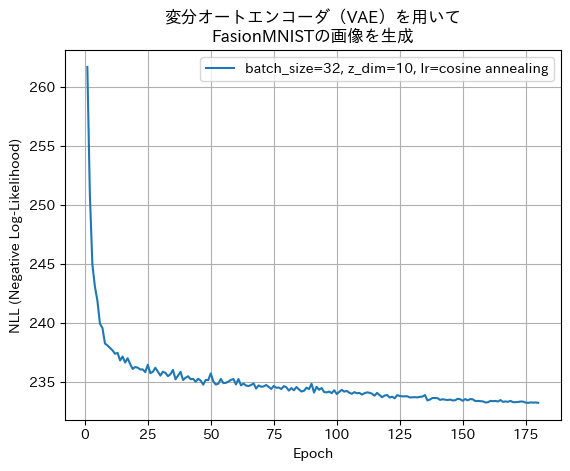

  2023/07/29 07:48:18 EPOCH:181, Train Lower Bound:234.608917, (13.291608, 221.317307), Valid Lower Bound:233.205414 lr=0.00002573 
  2023/07/29 07:48:26 EPOCH:182, Train Lower Bound:234.613144, (13.318672, 221.294495), Valid Lower Bound:233.191238 lr=0.00002324 最小値更新
  2023/07/29 07:48:33 EPOCH:183, Train Lower Bound:234.594086, (13.312969, 221.281097), Valid Lower Bound:233.244904 lr=0.00002088 
  2023/07/29 07:48:41 EPOCH:184, Train Lower Bound:234.581772, (13.302569, 221.279221), Valid Lower Bound:233.246857 lr=0.00001864 
  2023/07/29 07:48:48 EPOCH:185, Train Lower Bound:234.580841, (13.304517, 221.276321), Valid Lower Bound:233.175293 lr=0.00001652 最小値更新
  2023/07/29 07:48:56 EPOCH:186, Train Lower Bound:234.590729, (13.306626, 221.284119), Valid Lower Bound:233.245605 lr=0.00001453 
  2023/07/29 07:49:04 EPOCH:187, Train Lower Bound:234.566620, (13.300247, 221.266373), Valid Lower Bound:233.205078 lr=0.00001266 
  2023/07/29 07:49:11 EPOCH:188, Train Lower Bound:234.572662, (13

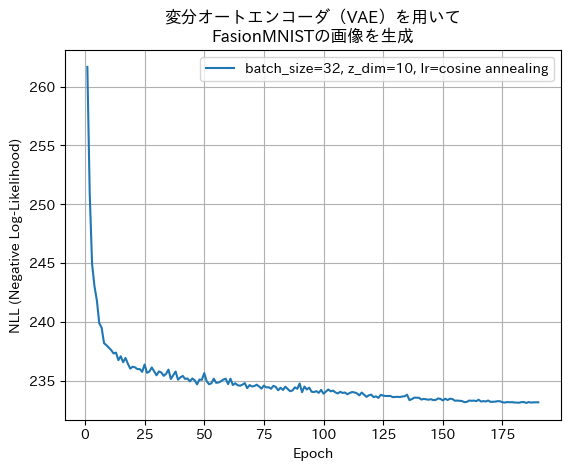

  2023/07/29 07:49:34 EPOCH:191, Train Lower Bound:234.542770, (13.307047, 221.235748), Valid Lower Bound:233.219650 lr=0.00000647 
  2023/07/29 07:49:42 EPOCH:192, Train Lower Bound:234.551041, (13.303348, 221.247696), Valid Lower Bound:233.187347 lr=0.00000525 
  2023/07/29 07:49:50 EPOCH:193, Train Lower Bound:234.552429, (13.317451, 221.234955), Valid Lower Bound:233.172150 lr=0.00000415 最小値更新
  2023/07/29 07:49:57 EPOCH:194, Train Lower Bound:234.559387, (13.324966, 221.234421), Valid Lower Bound:233.258194 lr=0.00000318 
  2023/07/29 07:50:05 EPOCH:195, Train Lower Bound:234.557877, (13.321891, 221.236008), Valid Lower Bound:233.159912 lr=0.00000233 最小値更新
  2023/07/29 07:50:13 EPOCH:196, Train Lower Bound:234.575974, (13.322498, 221.253464), Valid Lower Bound:233.250504 lr=0.00000162 
  2023/07/29 07:50:20 EPOCH:197, Train Lower Bound:234.528000, (13.318133, 221.209839), Valid Lower Bound:233.218475 lr=0.00000104 
  2023/07/29 07:50:28 EPOCH:198, Train Lower Bound:234.543457, (13

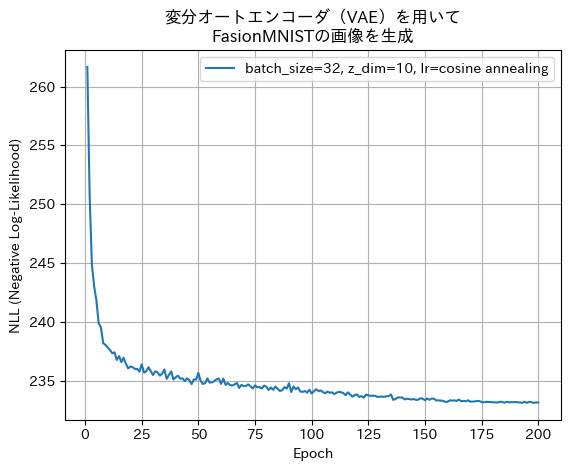

In [ ]:
z_dim = 10
assert z_dim >= 2
n_epochs = 200
lr=0.001     #0.00151 #0.001
scheduler = CosineScheduler(epochs=n_epochs, lr=lr)

model = VAE(z_dim).to(device)
#optimizer = optim.Adam(model.parameters(), lr=lr) #0.001
!pip install japanize_matplotlib >nul
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.clf()
gx = []
gy = []
title_font = {
    'color':  'black',
    'weight': 'bold',
    'size': 12,
}

min_valid_lower_bound = 9999                                                    # 最小値の初期値
for epoch in range(n_epochs):
    lr = scheduler(epoch)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.001


    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x in dataloader_train:

        # WRITE ME
        x = x.to(device)
        model.zero_grad()
        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)
        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in dataloader_valid:

        # WRITE ME
        x = x.to(device)
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())
    valid_lower_bound = np.average(losses_val)
    if valid_lower_bound < min_valid_lower_bound:
        min_valid_lower_bound = valid_lower_bound
        msg = "最小値更新"
    else:
        msg = ""
    xprint('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf lr=%.8lf %s' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val), lr, msg))
    gx.append(epoch+1)
    gy.append(np.average(losses_val))
    if (epoch+1) % 10 == 0:
        plt.plot(gx, gy, label=f'batch_size={batch_size}, z_dim={z_dim}, lr=cosine annealing')
        plt.xlabel(f"Epoch")                                     # グラフ表示用
        plt.ylabel(f"NLL (Negative Log-Likelihood)")                             # グラフ表示用
        plt.grid(True)
        plt.legend()
        plt.title(f"変分オートエンコーダ（VAE）を用いて\nFasionMNISTの画像を生成", fontdict=title_font)
        plt.show()

In [ ]:
import csv

sample_x = []
answer = []
model.eval()
for x in dataloader_test:
    x = x.to(device)
    y, _ = model(x)
    y = y.tolist()
    sample_x.extend(y)

with open('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/submission_pred.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(sample_x)
file.close()